In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [7]:
matches_df = pd.read_csv('../Datasets/final_feature_dataset.csv')
matches_df.head()
# matches_df.columns
# matches_df.shape

,Season,Home Team,Away Team,Home Goals,Away Goals,Home Team ELO,Away Team ELO,Home XG,Away XG,Home XGA,Away XGA,Home Win Percentage,Home Draw Percentage,Away Win Percentage,Away Draw Percentage,Home Team Form,Away Team Form,Home Team Cumulative Points,Away Team Cumulative Points,Winner
0,2014-2015,Manchester Utd,Swansea City,1,2,1676,1521,54.21,33.84,40.90,55.94,64.50,20.64,29.82,28.95,0.0,0.0,0,0,-1
1,2014-2015,West Brom,Sunderland,2,2,1485,1520,38.63,37.45,53.75,51.46,24.01,26.97,26.52,25.10,0.0,0.0,0,0,0
2,2014-2015,Leicester City,Everton,2,2,1462,1692,48.21,44.89,56.39,46.18,27.27,29.22,36.44,28.54,0.0,0.0,0,0,0
3,2014-2015,West Ham,Tottenham,0,1,1509,1680,46.69,57.40,52.39,57.04,32.51,25.29,39.62,25.83,0.0,0.0,0,0,-1
4,2014-2015,QPR,Hull City,0,1,1420,1434,45.73,65.26,32.79,46.99,30.42,24.58,21.05,26.32,0.0,0.0,0,0,-1


In [8]:
X = matches_df.drop(["Winner","Season",'Home Goals','Away Goals',"Home Team","Away Team"], axis=1)
y = matches_df["Winner"]

# categorical_columns = ["Home Team", "Away Team"]
# numerical_columns = [col for col in X.columns if col not in categorical_columns]

label_mapping = {-1: 0, 0: 1, 1: 2}
y_mapped = y.map(label_mapping)

X_train, X_test, y_train, y_test = train_test_split(X, y_mapped, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
mlp_model = MLPClassifier(hidden_layer_sizes=(128, 64, 32), activation='relu', solver='adam',
                          max_iter=1000, random_state=42)
mlp_model.fit(X_train_scaled, y_train)

MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42)

In [10]:
param_grid = {
    'hidden_layer_sizes': [(150, 75, 50)],
    'activation': ['tanh'],
    'solver': ['sgd'],
    'max_iter': [1000]
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=mlp_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train_scaled, y_train)

# Update the model with the best parameters
mlp_model = grid_search.best_estimator_


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\vimal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [11]:
print("Best Parameters:", grid_search.best_params_)
print("Number of possible fits:", len(grid_search.cv_results_['params']))
print("Best Score:", grid_search.best_score_)

Best Parameters: {'activation': 'tanh', 'hidden_layer_sizes': (150, 75, 50), 'max_iter': 1000, 'solver': 'sgd'}
Number of possible fits: 1
Best Score: 0.6641481256486191


In [12]:
y_pred = mlp_model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.6973684210526315
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.60      0.61       243
           1       0.75      0.75      0.75       161
           2       0.72      0.74      0.73       356

    accuracy                           0.70       760
   macro avg       0.70      0.70      0.70       760
weighted avg       0.70      0.70      0.70       760



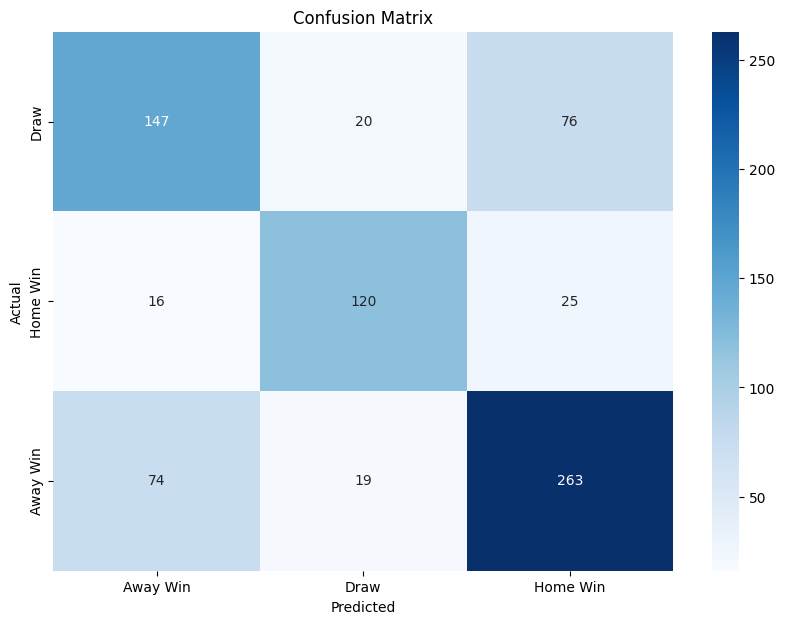

Class-wise Accuracy:
Class Away Win: 0.62
Class Draw: 0.75
Class Home Win: 0.72


In [13]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Away Win','Draw', 'Home Win'], yticklabels=['Draw', 'Home Win', 'Away Win'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

class_report = classification_report(y_test, y_pred, output_dict=True)
print("Class-wise Accuracy:")
for label, metrics in class_report.items():
    if label == '0':
        class_name = 'Away Win'
    elif label == '1':
        class_name = 'Draw'
    elif label == '2':
        class_name = 'Home Win'
    else:
        continue
    print(f"Class {class_name}: {metrics['precision']:.2f}")